In [2]:
%pip install opencv-python numpy tensorflow scikit-learn matplotlib wandb tdqm wurlitzer albumentations optuna


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Config

In [3]:
#all the required dependencies of the project
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import random
import wandb
import pandas as pd
import optuna

from typing import Tuple
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from typing import List
import json
import tensorflow.keras as keras 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from math import ceil

2024-04-24 10:37:26.584764: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 10:37:26.584803: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 10:37:26.584824: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 10:37:26.592986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class CONFIG:
    ROOT_DIRECTORY = os.path.join(".","manual-script-full")

    DEBUG = True
    
    P_OF_TRANSFORM = 0.8
    P_OF_TRANSFORM_COLOR = 0.2
    
    SHIFT_LIMIT=0.1
    SCALE_LIMIT=0.1
    ROTATE_LIMIT=15
    
    # set to small, when prototyping, or 0 when deploying to cloud or PC with loads of RAM
    DATA_LIMIT = 100
    VIDEO_LENGTH = 20
    
    BATCH_SIZE = 4
    PORTION_OF_DATA_FOR_TRAINING = 0.8

    ROUND_DIGIT = 3
    #WANDB_RUN = "mediapipe-asl-dataset"
    DECAY = 0.09
    
    USE_WANDB = True

    WANDB_RUN = "MHI-CNN"

## Utils

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
from wandb.keras import WandbMetricsLogger
import tensorflow as tf
import wandb
from math import sqrt


def visualize_video(frames, save_path=None, mult=2, show=True, labels=None):

    # calculate the grid
    image_cnt = frames.shape[0]
    rounded_cnt = ceil(sqrt(image_cnt))

    # calculate the width/height ratio
    ratio = frames.shape[1] / frames.shape[2]

    # create grid of arrays
    fig, axs = plt.subplots(rounded_cnt, rounded_cnt, figsize=( rounded_cnt*mult, ratio * rounded_cnt*mult))
    axs_flat = axs.flatten()

    # Loop through images and display each
    for i in range(rounded_cnt * rounded_cnt):
        if i < len(frames):
            axs_flat[i].imshow(frames[i])
        axs_flat[i].axis('off')  # Turn off axis

        title = f"{i}"

        if labels is not None:
            title += f" label={labels[i]}"

        axs_flat[i].set_title(title)

    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')        
    
    if show:
        plt.show()
    else:
        plt.close()


class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, run_name : str,
                train_ds, val_ds, dataset_name,
                max_lr = 1e-4, min_lr = 5e-5,
                T_max=50, epochs=100, verbose="auto",
                decay = 0.09,USE_WANDB=True): 
    
    global train_ds_len, val_ds_len, unique_labels_num
   
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)

    callbacks = [checkpoint]#, cosine_annealer]

    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model),
                        config={"max_lr" : max_lr, 
                                "min_lr" : min_lr, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : train_ds_len,
                                "val_size" : val_ds_len,
                                "unique_classes" : unique_labels_num, 
                                "video_length" : CONFIG.FRAME_SIZE,
                                "decay" : decay,
                                "SHIFT_LIMIT" : CONFIG.SHIFT_LIMIT,
                                "SCALE_LIMIT" : CONFIG.SCALE_LIMIT,
                                "ROTATE_LIMIT" : CONFIG.ROTATE_LIMIT,
                                "CACHEING" : dataset_name
                               })
        callbacks.append(WandbMetricsLogger())
    
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)
    #lr_metric = get_lr_metric(adam_optimizer)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    
    #history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[WandbMetricsLogger(), checkpoint, cosine_annealer])
    history = model.fit(train_ds, epochs=epochs, validation_data = val_ds, batch_size = CONFIG.BATCH_SIZE, callbacks=callbacks, verbose=verbose)
    #wandb.finish()
    if USE_WANDB:      
        wandb.finish()
    
    return history

# Cacheing Dataset definition

## Dataset definitions

In [6]:
def frame_diff2(prev, curr, kernel=np.array((5, 5), dtype=np.uint8),
                filter_size=3, filter_size_post=3, blocksize=15, C=3):
    frame_diff = cv2.subtract(curr, prev)
    frame_diff = cv2.medianBlur(frame_diff, filter_size)
    mask = cv2.adaptiveThreshold(frame_diff, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY_INV, blocksize, C)
    mask = cv2.medianBlur(mask, filter_size_post)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=1)
    return mask

def pseudocolor_generator(X, v1, v2, v3, v1_node, v2_node, v3_node, pow=1):
    I = X.astype(float) / 255.

    s1 = np.clip(1 - ((1. / ((v1_node - v1) ** 2)) * (v1 - I) ** 2) ** pow, 0, 1)
    s2 = np.clip(1 - ((1. / ((v2_node - v2) ** 2)) * (v2 - I) ** 2) ** pow, 0, 1)
    s3 = np.clip(1 - ((1. / ((v3_node - v3) ** 2)) * (v3 - I) ** 2) ** pow, 0, 1)

    ret = np.stack([s3, s2, s1], axis=2)

    return ret

def MHI_1(prev_mhi, frame_diff, tau=255, delta=32):
    next_MHI = np.zeros_like(prev_mhi).astype(int)

    next_MHI[frame_diff == 255] = tau
    next_MHI[frame_diff != 255] = np.clip(prev_mhi[frame_diff != 255].astype(int) - delta, 0, 255)

    return np.clip(next_MHI, 0, 255).astype(np.uint8)


def MHI_from_trajectory(traj : np.ndarray, tau : int, delta : int) -> np.ndarray:
    # timeframe, Width, height, channels
    ts, w, h, c = traj.shape
                        
    prev = np.zeros(shape=(w, h))
    mhi = None
        
    for i in range(1, ts):
        
        _prev = cv2.cvtColor((traj[i-1]).astype(np.uint8), cv2.COLOR_BGR2GRAY)
        _curr = cv2.cvtColor((traj[i]).astype(np.uint8), cv2.COLOR_BGR2GRAY)
            
        fd = frame_diff2(prev=_prev,curr=_curr)
        mhi = MHI_1(prev, fd, tau=tau, delta=delta)

        prev = mhi

    return mhi
    
    
def twosum_from_trajectory(traj : np.ndarray) -> np.ndarray:
    return traj

class BSLSignRecognitionDataset(keras.utils.Sequence):

    def __init__(self, cache_mode : str, 
                 is_dataset_for_training : bool,
                 video_length :  int = CONFIG.VIDEO_LENGTH,
                 post_mode : str = "identity",
                 tau :int = 255,
                 transform = None,
                 verbose : bool = True,
                 delta : int = 8,
                 v1 : float = 1/3, v2 : float = 2/3, v3 = 1.,
                 v1_node = 0, v2_node = 1, v3_node = 0.5, pow=1,
                 desired_shape = (224, 224)) -> None:
        # setup the paths
        
        self.unique_labels = []
        self.video_paths = []
        self.classes = []
        self.is_dataset_for_training = is_dataset_for_training
        self.video_length = video_length
        self.desired_shape = desired_shape
        self.cache_mode = cache_mode
        self.post_mode = post_mode
        self.tau = tau
        self.delta = delta
        self.v1, self.v2, self.v3 = v1, v2, v3
        self.v1_node, self.v2_node, self.v3_node = v1_node, v2_node, v3_node
        self.pow = pow
        self.mean = np.array([0.,0.,0.])
        self.std  = np.array([0.,0.,0.])
        self.cnt = 0
        self.transform = transform
        self.verbose = verbose

        for i,_class in enumerate(os.listdir(os.path.join(".", CONFIG.ROOT_DIRECTORY))):
            self.unique_labels.append(_class)
            
            for video in os.listdir(os.path.join(".", CONFIG.ROOT_DIRECTORY, _class)):
                self.video_paths.append(os.path.join( ".", CONFIG.ROOT_DIRECTORY, _class, video ))  
                self.classes.append(i)
                
        
        self.video_paths, self.classes = np.array(self.video_paths), np.array(self.classes)
        self._dataset = np.concatenate([ self.video_paths[:, np.newaxis], self.classes[:, np.newaxis] ], axis=1)
                

        train_ds, val_ds = train_test_split(self._dataset, train_size=CONFIG.PORTION_OF_DATA_FOR_TRAINING, 
                                            random_state=42, stratify=self._dataset[:, 1])
    

        if is_dataset_for_training == True:
            self.dataset = train_ds
        else:
            self.dataset = val_ds
    
        self.cache_dataset()    
        self.calculate_dataset_properties()    
    
    def cache_dataset(self):
        
        self.cached_X, self.cached_Y = [], []
        
        if self.verbose:
            pb = tqdm(self.dataset, desc="Cacheing")
        else:
            pb = self.dataset
        
        for point in pb:
            video_path, y = point
            trajectory = self.rescale_video(BSLSignRecognitionDataset.get_video(video_path),
                                            desired_shape=self.desired_shape)
            
            hotencoded = np.zeros(len(self.unique_labels))
            hotencoded[int(y)] = 1
            
            self.add_trajectory(trajectory, hotencoded)
            
    def calculate_dataset_properties(self):
        for el in self.cached_X:
            l = el.shape
            self.mean += np.sum( el, axis=tuple( range(len(l)-1)  ) )
            self.cnt += np.prod(l[:-1])     
        self.mean /= max(self.cnt,1)

        for el in self.cached_X:
             l = el.shape
             self.std += np.sum( (el - self.mean)**2, axis=tuple( range(len(l)-1)))
        self.std = np.sqrt(self.std / self.cnt)
        self.std = np.clip(self.std, 0.01, 10000)
        
    def get_mean_std(self):
        return self.mean, self.std
        
    def set_mean_std(self, mean, std):
        self.mean = mean
        self.std = std
        
        
    def normalize_data(self):
        for i in range(len(self.cached_X)):
            self.cached_X[i] = (self.cached_X[i] - self.mean) / self.std
                            
    def add_trajectory(self, traj : List[np.ndarray], label : np.ndarray):
        t, w, h, c = traj.shape       
 
        if self.cache_mode.lower() == "rgb":
            self.cached_X.append(traj.astype(float) / 255.)
            self.cached_Y.append(label)    
        
        elif self.cache_mode.lower() == "mhi":
            computed = []
            if t < self.video_length:
                computed.append(MHI_from_trajectory(traj, tau=self.tau, delta=self.delta).astype(float) / 255.)
            else:
                for i in range(t - self.video_length + 1):
                    computed.append(MHI_from_trajectory(traj[i : (i+self.video_length)], tau=self.tau, delta=self.delta).astype(float) / 255.)
            
            self.cached_X.append(np.array(computed))
            self.cached_Y.append(label)            
        
        elif self.cache_mode.lower() == "pseudocolor":
            computed = []
            if t < self.video_length:
                MHI = MHI_from_trajectory(traj, tau=self.tau, delta=self.delta)
                computed.append(pseudocolor_generator(MHI, self.v1, self.v2, self.v3, self.v1_node, self.v2_node, self.v3_node, pow=self.pow))
            else:
                for i in range(t - self.video_length + 1):
                    MHI = MHI_from_trajectory(traj[i : (i+self.video_length)], tau=self.tau, delta=self.delta)
                    computed.append(pseudocolor_generator(MHI, self.v1, self.v2, self.v3, self.v1_node, self.v2_node, self.v3_node, pow=self.pow))
            
            self.cached_X.append(np.array(computed))
            self.cached_Y.append(label)            
        
        elif self.cache_mode.lower() == "twosum-concat":
            return traj
                
        elif self.cache_mode.lower() == "twosum-stream":
            return traj
        elif self.cache_mode.lower() == "twosum-3d":
            return traj
        else:
            raise Exception(f"mode should be one of ['rgb', 'mhi', 'twosum-concat', 'twosum-stream', 'twosum-2d' 'pseudocolor']")        
        
    
    def preprocess_trajectory(self, traj : np.ndarray):
        return traj
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        datapoint, label = self.select(self.cached_X[idx]), self.cached_Y[idx]
        
        if self.transform is not None:
            datapoint = self.transform(image=datapoint)["image"]
        
        return datapoint, label


    def select(self, trajectory : np.array) -> np.array:
        
        
        if self.cache_mode.lower() == "rgb" or self.cache_mode.lower().startswith("twosum"):        
            if self.video_length != 0:
                frame_size = len(trajectory)
                start = 0 
                
                if frame_size > self.video_length:
                    start = np.random.randint(0, frame_size - self.video_length)
                trajectory = trajectory[start: (start + self.video_length)]
                        
                if len(trajectory) < self.video_length:
                    necessary = self.video_length - len(trajectory)
                    t, h, w, c = trajectory.shape
                    trajectory = np.concatenate([trajectory, np.zeros((necessary, h, w, c))], axis= 0)
                    
                return trajectory
            
        elif self.cache_mode.lower() == "mhi" or self.cache_mode.lower() == "pseudocolor":
            length = len(trajectory)
            return trajectory[np.random.randint(length)]
        
        else:
            raise Exception(f"mode should be one of ['rgb', 'mhi', 'twosum-concat', 'twosum-stream', 'twosum-2d' 'pseudocolor']")        
                
                
    @staticmethod
    def get_video(video_path : str) -> List[np.ndarray]:

        if not os.path.exists(video_path):
            return None

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            return None

        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                frame_array = np.array(frame)
                frames.append(cv2.cvtColor(frame_array, cv2.COLOR_BGR2RGB))
            else:
                break

        cap.release()
        return np.array(frames)

    @staticmethod
    def rescale_video(frames : np.ndarray, desired_shape) -> np.ndarray:
        refined = []
        for img in frames: 
            y, x, c = img.shape
            cropped = img[:, (x // 2 - y//2) : (x // 2 + y//2), :]
            scaled = cv2.resize(cropped, desired_shape)
            refined.append(scaled)
    
        return np.array(refined)


# MHI (pseudocolor)

## Dataset creation

In [7]:
transform = A.Compose(
    [
        A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=CONFIG.SHIFT_LIMIT, 
                           scale_limit=CONFIG.SCALE_LIMIT, rotate_limit=CONFIG.ROTATE_LIMIT),
    ]
)

In [8]:

tau, delta = 255, 14

train_ds = BSLSignRecognitionDataset(cache_mode="pseudocolor", tau=tau, delta=delta, transform=transform, is_dataset_for_training=True)
mean, std = train_ds.get_mean_std()
val_ds   = BSLSignRecognitionDataset(cache_mode="pseudocolor", tau=tau, delta=delta, is_dataset_for_training=False)
val_ds.set_mean_std(mean, std)

train_ds.normalize_data()
val_ds.normalize_data()

Cacheing:   3%|▎         | 5/160 [00:02<01:05,  2.36it/s]


KeyboardInterrupt: 

In [49]:
x, y = train_ds[0]
x_shape, y_shape = x.shape, y.shape


train_ds_len = len(train_ds)
val_ds_len = len(val_ds)
unique_labels_num = len(train_ds.unique_labels)

print(f"size of train_ds = {len(train_ds)}, size of val_ds = {len(val_ds)}")


def dataset_train_generator():
    # Instantiate your existing dataset loader

    for i in range(len(train_ds)):
        X_batch, Y_batch = train_ds[i]
        yield X_batch, Y_batch
        
def dataset_val_generator():
    # Instantiate your existing dataset loader

    for i in range(len(val_ds)):
        X_batch, Y_batch = val_ds[i]
        yield X_batch, Y_batch        

train_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_train_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: dataset_val_generator(),
    output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
    output_shapes=(x_shape, y_shape)
).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

size of train_ds = 160, size of val_ds = 40


In [50]:
train_labels = []
val_labels = []
nans = False

for x, y in tqdm(train_dataset, desc="iterating through train dataset"):
    labels = np.argmax(y, axis=1)
    for l in labels:
        train_labels.append(l)

    nans |= np.any(np.isnan(x))
print(f"nans = {nans}")        

for x, y in tqdm(val_dataset, desc="iterating through val dataset"):
    labels = np.argmax(y, axis=1)
    for l in labels:
        val_labels.append(l)
print(f"nans = {nans}")        

iterating through train dataset: 40it [00:00, 103.63it/s]


nans = False


iterating through val dataset: 10it [00:00, 100.26it/s]

nans = False


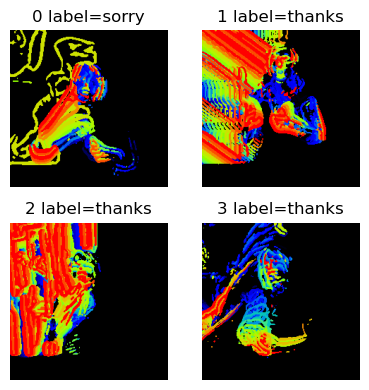

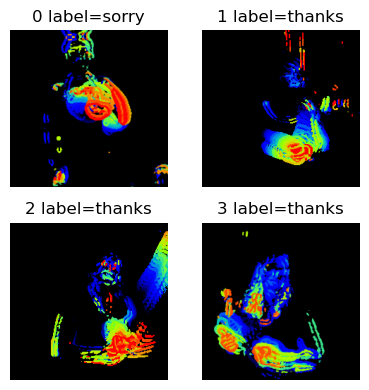

In [51]:

x, y = next(iter(val_dataset))
labels = [train_ds.unique_labels[k] for k in np.argmax(y, axis=1)]
visualize_video(x * val_ds.std + val_ds.mean, labels=labels, save_path="mhi_validation.png")


x, y = next(iter(train_dataset))
visualize_video(x * val_ds.std + val_ds.mean, labels=labels, save_path="mhi_train.png")

['sorry', 'thanks', 'sorry', 'thanks']


e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
e:\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


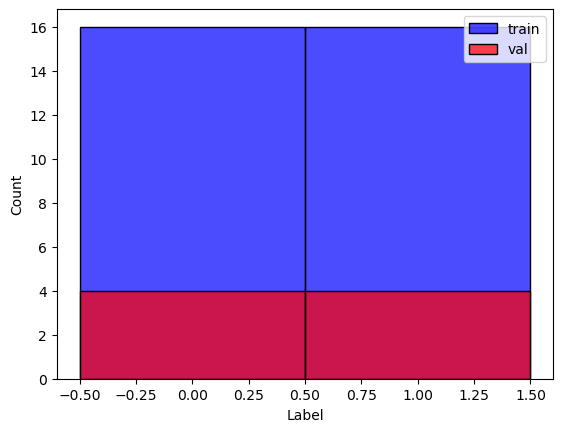

In [17]:
import seaborn as sns 

train_df_labels = pd.DataFrame(train_labels, columns=['Label'])
val_df_labels = pd.DataFrame(val_labels, columns=['Label'])


sns.histplot(train_df_labels, x="Label", alpha=0.7, discrete=True, kde=False, color="blue", label="train")
sns.histplot(val_df_labels, x="Label", alpha=0.7,discrete=True, kde=False, color="red", label="val")
plt.legend()
plt.show()

### MobileNetV3

In [18]:
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.MobileNetV3Small(input_shape = x_shape,
                                               include_top = False,
                                               weights = 'imagenet',
                                               pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(base_model)
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, run_name="C2_MobileNetV3Small_augmentation_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            max_lr = 1e-4, 
            min_lr = 5e-5,
            T_max=21, 
            epochs=40,
            filepath=os.path.join("models", "C2_MobileNetV3Small_no_transforms.keras"), 
            USE_WANDB=False)

Epoch 1/40
      8/Unknown 40s 67ms/step - categorical_accuracy: 0.4200 - loss: 9.2791

e:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 42s 351ms/step - categorical_accuracy: 0.4185 - loss: 9.1876 - val_categorical_accuracy: 0.5000 - val_loss: 1.2887
Epoch 2/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - categorical_accuracy: 0.6730 - loss: 3.5163 - val_categorical_accuracy: 0.5000 - val_loss: 1.4762
Epoch 3/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - categorical_accuracy: 0.4822 - loss: 3.7486 - val_categorical_accuracy: 0.5000 - val_loss: 1.7001
Epoch 4/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - categorical_accuracy: 0.5545 - loss: 2.5363 - val_categorical_accuracy: 0.5000 - val_loss: 1.8125
Epoch 5/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - categorical_accuracy: 0.4905 - loss: 2.5500 - val_categorical_accuracy: 0.5000 - val_loss: 1.9721
Epoch 6/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - categorical_accuracy: 0.6401 - loss: 1.7842 - val_categorical_accuracy: 0.5000 - val_loss: 1.9130
Epoch 7/40
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - categorical_accuracy: 0.8491 - loss: 0.5200 - val_categorical_ac

### EfficientNetB0

In [12]:
# get the base model, exclude final dense layers - we will modify/output this
base_model = tf.keras.applications.EfficientNetB0(input_shape = x_shape,
                                                include_top = False,
                                                weights = 'imagenet',
                                                pooling='max')
# Freeze the convolutional base
base_model.trainable = True

#len(train_ds.unique_labels) outputs the length of the labels.
#MobileNetV3 without additional dense layer - add softmax classification layer
model = Sequential()
model.add(keras.layers.Flatten())
model.add(Dense(256, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(Dense(len(train_ds.unique_labels), activation='softmax'))

keras_train(model, 
            run_name="EfficientNetB0_no_transforms", 
            train_ds=train_dataset, 
            val_ds=val_dataset, 
            T_max=11, 
            epochs=20,
            max_lr = 1e-4, 
            min_lr = 1e-5,
            dataset_name="calcMHI-augmentMHI_no_transforms", 
            filepath=os.path.join("models", "EfficientNetB0_no_transforms.keras"), 
            USE_WANDB=False)

Epoch 1/20
      8/Unknown 4s 195ms/step - categorical_accuracy: 0.4487 - loss: 1.6235

e:\Anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - categorical_accuracy: 0.4544 - loss: 1.6576 - val_categorical_accuracy: 0.6250 - val_loss: 4.0570
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - categorical_accuracy: 0.9237 - loss: 0.1437 - val_categorical_accuracy: 0.3750 - val_loss: 5.0912
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - categorical_accuracy: 1.0000 - loss: 0.0238 - val_categorical_accuracy: 0.3750 - val_loss: 5.3054
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - categorical_accuracy: 1.0000 - loss: 0.0086 - val_categorical_accuracy: 0.3750 - val_loss: 4.6303
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - categorical_accuracy: 1.0000 - loss: 0.0016 - val_categorical_accuracy: 0.5000 - val_loss: 4.4809
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - categorical_accuracy: 1.0000 - loss: 0.0018 - val_categorical_accuracy: 0.3750 - val_loss: 4.7664
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 200ms/step - categorical_accuracy: 1.0000 - loss: 0.0019 - val_categoric

# BO

In [10]:
from keras.layers import BatchNormalization, Dropout
import gc


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
from wandb.keras import WandbMetricsLogger
import tensorflow as tf
import wandb
from math import sqrt

class CosineAnnealingLearningRateScheduler(Callback):
    def __init__(self, max_lr, min_lr, T_max):
        super(CosineAnnealingLearningRateScheduler, self).__init__()
        self.max_lr = max_lr  # Maximum learning rate (i.e., start learning rate)
        self.min_lr = min_lr  # Minimum learning rate
        self.T_max = T_max    # Specifies the number of epochs per cycle
        self.t = 0            # Current epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.t += 1
        cos = np.cos(np.pi * (self.t % self.T_max) / self.T_max)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + cos)

        keras.backend.set_value(self.model.optimizer.lr, lr)

def keras_train(model, filepath : str, run_name : str,
                train_ds, val_ds, dataset_name,
                tau : int, delta : int,
                x, y,train_ds_len, val_ds_len,
                max_lr = 1e-4, min_lr = 5e-5,
                T_max=50, epochs=100, verbose="auto",
                decay = 0.09,USE_WANDB=True): 
    
    x_shape, y_shape = x.shape, y.shape
       
    checkpoint = keras.callbacks.ModelCheckpoint(filepath,
                                                 monitor="val_categorical_accuracy",
                                                 verbose=0,
                                                 save_best_only=True,
                                                 mode="max",
                                                 save_freq="epoch")
    
    cosine_annealer = CosineAnnealingLearningRateScheduler(max_lr=max_lr,
                                                           min_lr=min_lr,
                                                           T_max=T_max)

    callbacks = [checkpoint, cosine_annealer]
    #Adam Optimizer - fixed learning rate.
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate=max_lr, clipnorm=1.)
    #lr_metric = get_lr_metric(adam_optimizer)

    model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    
    if USE_WANDB:
        wandb.init(project=CONFIG.WANDB_RUN,
                        name=run_name,
                        notes="Model summary : \n" + str(model.summary()),
                        config={"max_lr" : max_lr, 
                                "min_lr" : min_lr, 
                                "scheduler" : "cosineAnnealer", 
                                "epochs" : epochs, 
                                "T_max" : T_max, 
                                "train_size" : train_ds_len,
                                "val_size" : val_ds_len,
                                "unique_classes" : 2, 
                                "video_length" : CONFIG.VIDEO_LENGTH,
                                "decay" : decay,
                                "SHIFT_LIMIT" : CONFIG.SHIFT_LIMIT,
                                "SCALE_LIMIT" : CONFIG.SCALE_LIMIT,
                                "ROTATE_LIMIT" : CONFIG.ROTATE_LIMIT,
                                "TAU" : tau,
                                "DELTA" : delta

                               })
        callbacks.append(WandbMetricsLogger())
        
    
    #history = model.fit(train_dataset_parquet, epochs=epochs, validation_data = val_dataset_parquet, batch_size = 8, callbacks=[WandbMetricsLogger(), checkpoint, cosine_annealer])
    history = model.fit(train_ds, epochs=epochs, validation_data = val_ds, batch_size = CONFIG.BATCH_SIZE, callbacks=callbacks, verbose=verbose)
    #wandb.finish()
    if USE_WANDB:      
        wandb.finish()
    
    return history
    

transform = A.Compose(
    [
        A.HorizontalFlip(p=CONFIG.P_OF_TRANSFORM),
        A.ShiftScaleRotate(p=CONFIG.P_OF_TRANSFORM, shift_limit=CONFIG.SHIFT_LIMIT, 
                           scale_limit=CONFIG.SCALE_LIMIT, rotate_limit=CONFIG.ROTATE_LIMIT),
    ]
)

def BO_experiment(trial):
    
    # BO suggest parameters
    suggested_tau = trial.suggest_int('tau', 0, 255)
    suggested_delta = trial.suggest_int("delta", 0, suggested_tau+1)
    
    tau, delta = suggested_tau, suggested_delta

    train_ds = BSLSignRecognitionDataset(cache_mode="pseudocolor", tau=tau, delta=delta, verbose=False, transform=transform, is_dataset_for_training=True)
    mean, std = train_ds.get_mean_std()
    val_ds   = BSLSignRecognitionDataset(cache_mode="pseudocolor", tau=tau, delta=delta, verbose=False, is_dataset_for_training=False)
    val_ds.set_mean_std(mean, std)

    train_ds.normalize_data()
    val_ds.normalize_data()

    train_ds_len = len(train_ds)
    val_ds_len = len(val_ds)
    unique_labels_num = 2

    x, y = next(iter(train_ds))
    x_shape = x.shape
    y_shape = y.shape
    
    
    def dataset_train_generator():
        # Instantiate your existing dataset loader
        for i in range(len(train_ds)):
            X_batch, Y_batch = train_ds[i]
            yield X_batch, Y_batch
        
    def dataset_val_generator():
        # Instantiate your existing dataset loader

        for i in range(len(val_ds)):
            X_batch, Y_batch = val_ds[i]
            yield X_batch, Y_batch        

    train_dataset = tf.data.Dataset.from_generator(
        lambda: dataset_train_generator(),
        output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
        output_shapes=(x_shape, y_shape)
    ).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)

    val_dataset = tf.data.Dataset.from_generator(
        lambda: dataset_val_generator(),
        output_types=(tf.float32, tf.float32),  # Adjust types based on your actual data
        output_shapes=(x_shape, y_shape)
    ).prefetch(tf.data.AUTOTUNE).batch(CONFIG.BATCH_SIZE)   
    
    
    # get the base model, exclude final dense layers - we will modify/output this
    base_model = tf.keras.applications.EfficientNetB0(input_shape = x_shape,
                                                    include_top = False,
                                                    weights = 'imagenet',
                                                    pooling='max')
    # Freeze the convolutional base
    base_model.trainable = True

    #len(train_ds.unique_labels) outputs the length of the labels.
    #MobileNetV3 without additional dense layer - add softmax classification layer
    model = Sequential()
    model.add(base_model)
    model.add(Dense(128, activation="relu"))
    model.add(keras.layers.BatchNormalization())
    model.add(Dense(len(train_ds.unique_labels), activation='softmax'))
    model.build(x_shape)

    hist = keras_train(model, 
                run_name="EfficientNetB0_BSL_augmentation_BO", 
                train_ds=train_dataset, 
                val_ds=val_dataset, 
                T_max=31, 
                verbose=0,
                epochs=30,
                x=x,y=y,train_ds_len=train_ds_len, val_ds_len=val_ds_len,
                tau = tau,
                delta=delta,
                max_lr = 1e-4, 
                min_lr = 2.5e-5,
                dataset_name="BSL", 
                filepath=os.path.join("models", f"EfficientNetB0_tau={tau}_delta={delta}.tf"), 
                USE_WANDB=True)
        
    del train_ds
    del val_ds
    del train_dataset
    del val_dataset
    del model
    gc.collect()

    return max(hist.history['val_categorical_accuracy'])


study = optuna.create_study(direction="maximize", storage='sqlite:///optunastudy.db')
study.optimize(BO_experiment, n_trials=40)

[I 2024-04-24 10:43:19,642] A new study created in RDB with name: no-name-b68f7aca-4759-4c99-b53b-d1a41dd5f42f


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


epoch/categorical_accuracy,▁▅██
epoch/epoch,▁▃▆█
epoch/learning_rate,█▇▄▁
epoch/loss,█▂▁▁
epoch/val_categorical_accuracy,█▁▃▅
epoch/val_loss,▁▄▇█
epoch/categorical_accuracy,0.59375
epoch/epoch,3
epoch/learning_rate,0.0001
epoch/loss,0.7911
epoch/val_categorical_accuracy,0.475


2024-04-24 10:45:09.236951: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=81_delta=11.tf/assets


epoch/categorical_accuracy,▁▂▂▃▃▄▄▃▅▃▄▄▆▆▇▆▆▇▆▇▇█▇▇█▆██▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,██▆▅▆▅▅▅▄▅▄▄▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁
epoch/val_categorical_accuracy,▄▄▄▄▄▄▃▁▆▄▄▅▆▂▆▅▄▅▄▅▇▇█▇▇▆▂▅▇▇
epoch/val_loss,▂▁▁▁▁▂▁▁▁▂▂▁▁▁▁▁▃▂▂▂▂▁▂▁▂▆█▇▁▂
epoch/categorical_accuracy,0.8375
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.41761
epoch/val_categorical_accuracy,0.625


[I 2024-04-24 10:50:55,974] Trial 0 finished with value: 0.675000011920929 and parameters: {'tau': 81, 'delta': 11}. Best is trial 0 with value: 0.675000011920929.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 10:52:43.186356: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=168_delta=140.tf/assets


epoch/categorical_accuracy,▁▃▂▄▃▃▄▅▅▅▅▅▄▇▆▇▇▇▇▆▅▆▆▅▆█▆▆▆▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▅▆▄▇▅▃▄▄▄▄▂▃▂▃▁▂▃▁▂▁▂▂▂▂▁▂▁▂▁
epoch/val_categorical_accuracy,▄▅▅▅▄▆▆▅▃▂▄▄▂▃▄▅▅▄▁▅▅▇█▆▆▅▅▆▇▅
epoch/val_loss,▁▂▂▂▂▂▂▂▂▄▃▄▃▅▆▇▆▄▄▅▆▄▂▅▄▇▇█▂▁
epoch/categorical_accuracy,0.725
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.56133
epoch/val_categorical_accuracy,0.5


[I 2024-04-24 10:59:33,222] Trial 1 finished with value: 0.625 and parameters: {'tau': 168, 'delta': 140}. Best is trial 0 with value: 0.675000011920929.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 11:01:18.171578: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=249_delta=237.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=249_delta=237.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=249_delta=237.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=249_delta=237.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=249_delta=237.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=249_delta=237.tf/assets


epoch/categorical_accuracy,▁▁▁▂▅▄▅▅▅▄▆▆▆▅▄▇▆▆▆▆█▆▆▅▇▇█▇▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,▇█▆▅▃▄▄▅▃▄▃▃▂▃▄▂▃▂▃▃▂▃▄▃▂▃▁▂▁▂
epoch/val_categorical_accuracy,▂▁▄▄▄▁█▄▅▂▂▅▄▂▂▄▅▄▁▄▅▂▅▃▂▃▇▅▅▇
epoch/val_loss,▁▁▁▁▂▂▁▁▁▄▂▁▂▂▆▂▂▂▃▂▂▂▂▂▄█▂▂▂▂
epoch/categorical_accuracy,0.74375
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.54992
epoch/val_categorical_accuracy,0.675


[I 2024-04-24 11:05:53,521] Trial 2 finished with value: 0.7250000238418579 and parameters: {'tau': 249, 'delta': 237}. Best is trial 2 with value: 0.7250000238418579.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization_4 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 11:07:37.771170: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=139_delta=66.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=139_delta=66.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=139_delta=66.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=139_delta=66.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=139_delta=66.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=139_delta=66.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=139_delta=66.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=139_delta=66.tf/assets


epoch/categorical_accuracy,▂▄▃▂▃▄▃▂▃▁▆▄▅▄▆▆▅▇▅▆▆▆▆█▇▅▇▆▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▆█▆▆▅▆▅▆▆▃▄▄▅▃▃▄▃▃▂▃▃▄▁▂▃▄▃▂▂
epoch/val_categorical_accuracy,▅▅▅▅▆▂▇▅▆▃█▆▇▅▇▃█▅▃▃▇▃▃▆▄▅▅▇▁▇
epoch/val_loss,▁▁▁▁▁▂▁▁▁▂▁▂▁▂▂▆▂▃▅▆▂▃▃█▅▅█▆▂▃
epoch/categorical_accuracy,0.75625
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.51233
epoch/val_categorical_accuracy,0.6


[I 2024-04-24 11:12:44,129] Trial 3 finished with value: 0.6499999761581421 and parameters: {'tau': 139, 'delta': 66}. Best is trial 2 with value: 0.7250000238418579.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_10 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 11:14:29.683983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=14_delta=8.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=14_delta=8.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=14_delta=8.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=14_delta=8.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=14_delta=8.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=14_delta=8.tf/assets


epoch/categorical_accuracy,▁▃▂▄▃▄▃▄▅▅▅▅▄▅▆▅▅▇▅█▆▇▇▆▆▆▆▆▇▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▅▇▅▅▅▅▄▄▅▃▄▄▃▃▃▃▂▄▁▂▂▂▄▃▂▂▂▂▂
epoch/val_categorical_accuracy,▄▄▄▄▄▆▅▆▃▄▂▄▃▅▄▆▂▆▃▅▁▃▄▆▃█▄▅█▅
epoch/val_loss,▂▂▂▁▂▂▁▁▁▂▂▂▃▃▂▁▃▂▂▂▂█▃▂▂▅▇▅██
epoch/categorical_accuracy,0.66875
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.61797
epoch/val_categorical_accuracy,0.525


[I 2024-04-24 11:18:43,155] Trial 4 finished with value: 0.6000000238418579 and parameters: {'tau': 14, 'delta': 8}. Best is trial 2 with value: 0.7250000238418579.


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_12 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 11:20:29.629777: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=26_delta=1.tf/assets


epoch/categorical_accuracy,▁▂▃▄▅▄▆▅▅▆▇▆▆▇▇▇▇▇██▇▇█▇▇▇████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▆▅▄▅▃▄▃▄▃▃▃▃▂▃▂▃▁▁▂▁▁▂▁▁▁▂▁▁
epoch/val_categorical_accuracy,▃▃▃▃▃▃▃▁▃▄▇▆▄▄▃▅▆▅▅▅█▆▇▄▃▄▄▃▅▂
epoch/val_loss,▂▂▃▂▂▃▃▃▂▂▂▂▂▆█▃▂▄▃▃▁▂▃▂▄▆▆▆▅▆
epoch/categorical_accuracy,0.88125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.3019
epoch/val_categorical_accuracy,0.45


[I 2024-04-24 11:26:53,039] Trial 5 finished with value: 0.800000011920929 and parameters: {'tau': 26, 'delta': 1}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_7 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 11:28:32.961544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=243_delta=33.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=243_delta=33.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=243_delta=33.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=243_delta=33.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=243_delta=33.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=243_delta=33.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=243_delta=33.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=243_delta=33.tf/assets


epoch/categorical_accuracy,▂▂▁▄▃▃▄▄▅▆▅▆▆▇▆▆▇▇▆▆▇▇▇▇▆▇▇▇▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,███▅█▅▆▅▄▄▄▃▅▂▄▃▃▂▃▃▂▃▁▂▂▂▂▂▂▁
epoch/val_categorical_accuracy,▂▂▁▃▂▂▃▄█▂▃▂▄▂▁▅▂▁▂▄▆▂▃▅▆▃▂▄▆▃
epoch/val_loss,▂▂▂▃▂▂▂▂▁▂▃▄▂▂▃▁▄█▆▆▂▄▃▂▂▄▄▃▂▄
epoch/categorical_accuracy,0.83125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.39076
epoch/val_categorical_accuracy,0.55


[I 2024-04-24 11:33:41,522] Trial 6 finished with value: 0.75 and parameters: {'tau': 243, 'delta': 33}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_16 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 11:35:23.065566: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=177_delta=118.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=177_delta=118.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=177_delta=118.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=177_delta=118.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=177_delta=118.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=177_delta=118.tf/assets


epoch/categorical_accuracy,▁▃▃▃▁▂▂▃▃▅▆▆▃▅▅▅▅▄▇▅▇▇▅▆█▆▅▅▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▆█▆▆▆▇▄▆▃▄▃▆▄▅▃▃▃▂▃▂▃▃▃▂▃▃▄▂▁
epoch/val_categorical_accuracy,▄▄▄▇▅▆▇▇▇▆▆▇▇█▆▆▃▇▆▃▅▁▆▇▆▄▅▄▃▄
epoch/val_loss,▁▁▁▁▁▂▁▁▂▂▂▂▂▁▃▂▃▂▅▅▄█▄▃▅▆▅▇▅▆
epoch/categorical_accuracy,0.74375
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.53234
epoch/val_categorical_accuracy,0.425


[I 2024-04-24 11:39:38,570] Trial 7 finished with value: 0.6499999761581421 and parameters: {'tau': 177, 'delta': 118}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_18 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_9 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 11:41:20.854727: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-24 11:41:37.746030: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13207818481717996255
2024-04-24 11:41:37.746103: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12779482712467138337
2024-04-24 11:41:37.746125: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10661355723029358156


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=69_delta=61.tf/assets


epoch/categorical_accuracy,▁▂▃▁▅▃▁▄▃▄▄▄▄▄▅▇▅▄▇▇▅▆▅▇▇▆▇▆▆█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,▇█▆▇▄▆▆▄▄▄▄▅▅▄▃▂▄▄▂▁▃▂▂▃▂▃▁▁▂▁
epoch/val_categorical_accuracy,▅▅▃▅▄▆▄▁▃▃▆▃▅▆▂▇▃▁▆▆▇█▆▅▄▁▄▇▇▆
epoch/val_loss,▁▂▁▁▁▂▂▂▁▂▁▂▂▁▄▂▂▂▂▁▂▂▁▂█▇▄▂▂▇
epoch/categorical_accuracy,0.73125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.57944
epoch/val_categorical_accuracy,0.55


[I 2024-04-24 11:47:22,713] Trial 8 finished with value: 0.6000000238418579 and parameters: {'tau': 69, 'delta': 61}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_20 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_10 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_21 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 11:49:03.738221: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=27_delta=26.tf/assets


epoch/categorical_accuracy,▁▃▄▃▃▃▂▃▆▄▃▅▃▃▆▃▆▇▆▅▄▆▆▇█▅▆▇▆▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▄▄▄▄▅▅▂▃▃▃▃▃▂▃▂▁▃▃▃▂▁▂▂▃▂▁▂▂
epoch/val_categorical_accuracy,▄▅▅▃▄▅▆▇▆▄█▆▁▃▁▄▂▆▆▂▅▄▄█▃▄▄▄▅▄
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▂▁▁▁▁▂▁▂▁▂▁
epoch/categorical_accuracy,0.6625
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.64373
epoch/val_categorical_accuracy,0.5


[I 2024-04-24 11:55:07,321] Trial 9 finished with value: 0.6499999761581421 and parameters: {'tau': 27, 'delta': 26}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_22 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_11 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_23 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 11:56:49.792790: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=79_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=79_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=79_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=79_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=79_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=79_delta=0.tf/assets


epoch/categorical_accuracy,▂▁▄▄▅▅▅▆▅▆▆▆▆▇▆▇▇▆▇▇▇▇███▇▇███
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,██▅▅▄▄▄▃▄▄▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂
epoch/val_categorical_accuracy,▃▃▃▃▃▃▃▃▃▃▇▃▄▄▃▅▅▆▄▅▂▂▃▂▂▆▃█▅▁
epoch/val_loss,▁▁▁▂▁▃▂▂▃▂▁▂▁▂▂▂▂▂▃█▅▃▂▄▂▂▃▁▂▃
epoch/categorical_accuracy,0.86875
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.35983
epoch/val_categorical_accuracy,0.425


[I 2024-04-24 12:01:06,174] Trial 10 finished with value: 0.675000011920929 and parameters: {'tau': 79, 'delta': 0}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_24 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 12:02:47.131565: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_12/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=245_delta=73.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=245_delta=73.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=245_delta=73.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=245_delta=73.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=245_delta=73.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=245_delta=73.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=245_delta=73.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=245_delta=73.tf/assets


epoch/categorical_accuracy,▁▂▃▂▃▄▃▃▅▅▆▅▆▆▇▆▇█▇▇▇▇█▇▆█▇▇▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▆▇▆▅▅▆▅▄▄▄▃▃▃▃▂▃▂▃▂▃▁▂▃▁▁▂▂▂
epoch/val_categorical_accuracy,▅▅▅▅▇▆▄▅▇▃▅▇▄▅▆▃▅▁▄▇█▆▇▆▆▇▄▆▄▆
epoch/val_loss,▁▁▁▁▁▁▁▁▁▂▁▁▂▂▅█▆▆▆▃▂▃▂▂▄▃▂▆▃▂
epoch/categorical_accuracy,0.75625
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.53316
epoch/val_categorical_accuracy,0.525


[I 2024-04-24 12:07:54,914] Trial 11 finished with value: 0.6000000238418579 and parameters: {'tau': 245, 'delta': 73}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_26 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_13 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_27 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 12:09:37.075527: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_13/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=209_delta=44.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=209_delta=44.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=209_delta=44.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=209_delta=44.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=209_delta=44.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=209_delta=44.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=209_delta=44.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=209_delta=44.tf/assets


epoch/categorical_accuracy,▁▂▁▄▃▄▄▃▄▄▄▅▄▆▆▇▆▇▆▆▇▆▆▆▇▇▇▇█▅
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,███▅▆▆▄▅▅▄▄▄▅▃▄▂▃▂▃▃▂▃▃▃▂▂▁▂▁▂
epoch/val_categorical_accuracy,▂▂▅▅▇▄█▄▇▃▂▆▅▄▄▇▃▄▂▆▁▁▁▆▅█▆▅▅▄
epoch/val_loss,▅▂▁▁▁▁▁▂▂▄▂▃▂▅▄▂▃▃▄▄▇▇▅█▅▃▃▃▄▅
epoch/categorical_accuracy,0.69375
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.5
epoch/val_categorical_accuracy,0.55


[I 2024-04-24 12:14:47,883] Trial 12 finished with value: 0.699999988079071 and parameters: {'tau': 209, 'delta': 44}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_28 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_14 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_29 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 12:16:30.468591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=116_delta=30.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=116_delta=30.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=116_delta=30.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=116_delta=30.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=116_delta=30.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=116_delta=30.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=116_delta=30.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=116_delta=30.tf/assets


epoch/categorical_accuracy,▁▃▂▂▃▄▄▄▅▃▆▄▆▅█▇▇▇▄█▆▇██▆▆█▇▅█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,██▆▇▆▆▆▆▅▅▃▄▄▃▂▂▂▂▅▂▂▂▃▁▃▂▂▃▃▁
epoch/val_categorical_accuracy,▅▄▃▄▄▃▅▅▅▆▄▅█▁▃█▅▄▆█▅▇▅▃▆▅▆▄▅▄
epoch/val_loss,▃▅▄▄▂▅▂▂▅▄▃▃▁▃▄▄▅▄▃▁▅▃▅▄▆▅▃▂█▂
epoch/categorical_accuracy,0.73125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.53801
epoch/val_categorical_accuracy,0.475


[I 2024-04-24 12:21:44,747] Trial 13 finished with value: 0.675000011920929 and parameters: {'tau': 116, 'delta': 30}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_30 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_15 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_31 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 12:23:26.484926: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_15/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=39_delta=17.tf/assets


epoch/categorical_accuracy,▁▂▂▄▄▄▆▄▅▅▃▄▅▆▅▅▅▅▇▆▇▆▇▅▆▆▇█▇▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▆▅▅▃▄▃▄▃▃▅▄▃▃▃▃▃▃▂▂▂▃▂▃▂▂▂▁▂▂
epoch/val_categorical_accuracy,▅▅▂▄▃▄▆▁▅▂▆▆▄▆▆▃▄▅▆▇▆▄▃▆▆▇▅█▆▅
epoch/val_loss,▄▃▁▁▂▁▁▂▁▁▂▂▁▁▄▄▃▂▂█▁▅▃▂▅▁▂▅▅▂
epoch/categorical_accuracy,0.6875
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.58712
epoch/val_categorical_accuracy,0.525


[I 2024-04-24 12:30:31,585] Trial 14 finished with value: 0.6499999761581421 and parameters: {'tau': 39, 'delta': 17}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_32 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_16 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_33 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 12:32:13.367969: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=102.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=102.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=102.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=102.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=102.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=102.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=102.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=102.tf/assets


epoch/categorical_accuracy,▁▂▃▃▃▄▂▂▄▃▄▅▅▆▅▆▅▅▆▇▇▅▄▇▅█▆▅▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▅▅▆▇▄▅▅▃▄▄▄▄▂▄▄▃▄▄▂▂▄▃▂▂▁▂▂▁▁
epoch/val_categorical_accuracy,▁▄▅█▁▂▂▇▂▄▆▅▂▄▅▂▂▄▁▃▄▄▂▅▄▃▂▄▅▅
epoch/val_loss,▂▂▂▁▂▂▁▁▁▂▁▃▂▂▂▃▅▂▇▆█▁▆▆▃▅▆▂▃▄
epoch/categorical_accuracy,0.7375
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.55423
epoch/val_categorical_accuracy,0.575


[I 2024-04-24 12:37:27,900] Trial 15 finished with value: 0.675000011920929 and parameters: {'tau': 206, 'delta': 102}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_34 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_17 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_35 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 12:39:12.882068: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=117_delta=41.tf/assets


epoch/categorical_accuracy,▃▂▃▃▁▄▄▄▄▅▅▅▅▆█▄▅▅▅▆▆▆▆▅▇▇▇▇▆▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,▆█▇▆▆▅▅▄▃▄▄▄▄▃▂▄▃▂▂▂▂▂▂▃▂▁▂▁▁▁
epoch/val_categorical_accuracy,▃▃▄▂▂▆▃▂▃▂▃▃▃▇▂█▅▄▅▁▆▄▅▅▆▇▇▆▄▆
epoch/val_loss,▁▁▁▁▂▁▂▂▂▂▂▁▂▂█▁▂▅▃▄▂▃▂▄▃▂▄▅▆▃
epoch/categorical_accuracy,0.70625
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.52551
epoch/val_categorical_accuracy,0.625


[I 2024-04-24 12:46:40,806] Trial 16 finished with value: 0.7250000238418579 and parameters: {'tau': 117, 'delta': 41}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_36 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_18 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_37 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 12:48:21.417802: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=26.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=26.tf/assets


epoch/categorical_accuracy,▁▃▁▂▃▂▃▅▃▆▆▄▄▄▆▆▅▇▆█▆▇▇█▆▇▆▆▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇██▆▆▆▄▆▃▄▄▄▄▃▂▃▃▃▂▃▂▃▁▂▂▂▃▂▁
epoch/val_categorical_accuracy,▅▅▆▅▆█▆▇▆▇▇▅▆▆▆█▅▆▆▇█▇▆█▁▆▆▇▇▆
epoch/val_loss,▂▁▁▂▁▁▂▂▂▁▁▂▂▂▂▃▂▃▅▅▂▁█▇▄▄▅▂▂▄
epoch/categorical_accuracy,0.7375
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.53997
epoch/val_categorical_accuracy,0.55


[I 2024-04-24 12:53:41,662] Trial 17 finished with value: 0.6499999761581421 and parameters: {'tau': 54, 'delta': 26}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_38 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_19 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_39 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 12:55:25.957906: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_19/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=5_delta=0.tf/assets


epoch/categorical_accuracy,▁▂▃▄▅▅▄▅▇▅▆▆▆▆▇▇▇▇▇▇▇██▇▇█▇██▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,██▆▅▄▅▅▄▃▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▂▁▂▁▂▂
epoch/val_categorical_accuracy,▄▄▄▄▄▄▅▄▄▅▆▄▄▄▇▆▆▁▂▄▃█▄▆▄▃█▃▅▆
epoch/val_loss,▁▂▂▆▃▂▁▁▁▁▁▃▄▃▁▁▅▃▂█▄▁▄▂▃▂▂▃▂▂
epoch/categorical_accuracy,0.84375
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.36711
epoch/val_categorical_accuracy,0.55


[I 2024-04-24 13:01:39,333] Trial 18 finished with value: 0.625 and parameters: {'tau': 5, 'delta': 0}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_40 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_20 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_41 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 13:03:20.479703: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_20/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=141_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=141_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=141_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=141_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=141_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=141_delta=47.tf/assets


epoch/categorical_accuracy,▁▁▃▅▃▅▄▄▄▅▅▅▄▄▅▅▅▆▅▆▅▅▇▆█▇▆▅▆▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▆▄▇▄▅▅▅▄▄▄▄▃▄▃▄▃▃▃▂▃▂▂▁▂▃▃▂▂
epoch/val_categorical_accuracy,▄▄▇▂▃▆▄▂▄▁▄▅█▄▃▄▂▆▇▇▅▅▇▂▇▇█▃▇▅
epoch/val_loss,▄▃▂▄▃▂▂▃▃▃▃▃▃▂▄▅▄▄▂▂▃▄██▅▄▁▅▅▅
epoch/categorical_accuracy,0.75
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.55349
epoch/val_categorical_accuracy,0.55


[I 2024-04-24 13:07:41,531] Trial 19 finished with value: 0.6499999761581421 and parameters: {'tau': 141, 'delta': 47}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_42 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_21 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_43 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 13:09:23.436307: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_21/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=98_delta=36.tf/assets


epoch/categorical_accuracy,▂▁▂▁▂▄▄▃▃▄▄▅▆▅▇▄▇▇▄▆▇█▆▆█▆▇█▇▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,▇█▆▆▆▄▅▆▅▄▆▃▄▃▂▄▁▂▅▂▂▁▃▃▁▂▁▂▂▁
epoch/val_categorical_accuracy,▂▅▂▄▁▅▇▄▄▄▅▇▆▇▄▇▇█▅▇▇▅▇▆▂▄▅▃▆█
epoch/val_loss,▁▁▁▁▁▁▁▁▂▁▂▂▂▁▃▂▂▂▁▂▇▆█▄▅▆▅▅▁▂
epoch/categorical_accuracy,0.73125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.52406
epoch/val_categorical_accuracy,0.65


[I 2024-04-24 13:15:33,861] Trial 20 finished with value: 0.6499999761581421 and parameters: {'tau': 98, 'delta': 36}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_44 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_22 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_45 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 13:17:14.821425: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=255_delta=225.tf/assets


epoch/categorical_accuracy,▂▁▄▄▅▅▄▅▅▄▄▄▅▆▅▄▇▇▇█▆▆▇▆▆▇▇▆▇▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,██▆█▆▄▅▄▄▅▄▃▃▄▄▃▃▂▃▂▃▂▂▃▃▃▃▂▁▃
epoch/val_categorical_accuracy,▄▄▁▅▂▄▄▂▃▂▄▂▄▃▇▄██▁▆▅▅▄▄▅▅▄▂▄▄
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁█▁▂▁▁▁
epoch/categorical_accuracy,0.68125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.60932
epoch/val_categorical_accuracy,0.5


[I 2024-04-24 13:23:27,970] Trial 21 finished with value: 0.6499999761581421 and parameters: {'tau': 255, 'delta': 225}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_46 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_23 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_47 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 13:25:14.990005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_23/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=184.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=184.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=184.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=184.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=184.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=184.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=184.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=184.tf/assets


epoch/categorical_accuracy,▁▃▃▂▄▃▃▄▄▂▃▅▄▅▆▆▆▄▆▅▇▆▆▇▇▆▅▆█▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▆▅█▆▇▆▅▅▅▅▄▄▃▃▃▃▄▃▄▃▃▃▂▂▄▃▃▁▂
epoch/val_categorical_accuracy,▅▆▇█▅▇▅▄▅▄▆▃▆▄▅▆▁▄▅▃▃▄▅▇▆▅▆▇▆▇
epoch/val_loss,▁▁▁▁▁▂▂▂▂▂▁▂▂▂▃▂▃▃▅▅█▄▅▂▂▄▃▂▂▂
epoch/categorical_accuracy,0.73125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.57553
epoch/val_categorical_accuracy,0.6


[I 2024-04-24 13:30:36,686] Trial 22 finished with value: 0.6499999761581421 and parameters: {'tau': 226, 'delta': 184}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_48 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_24 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_49 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 13:32:17.827544: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_24/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=186_delta=87.tf/assets


epoch/categorical_accuracy,▁▂▃▄▄▃▄▄▆▄▇▅▅▅▅▇▇▆▇▆▆▇▆▇█▇▆▆▇█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▅▆▅▅▅▄▄▅▂▄▃▃▄▂▂▃▂▃▃▂▂▃▁▂▂▂▂▂
epoch/val_categorical_accuracy,▄▁▂▃▆▆▃▄▆▃▅▅▇▆▆▅▂▆▅▇▃█▃▄▅▅▆▇▆▄
epoch/val_loss,▂▃▄▃▄▇▇▂▁▂▄▂▁▁▂▄▅▂▄▄▆▃██▅▄▃▃▃▆
epoch/categorical_accuracy,0.75625
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.56624
epoch/val_categorical_accuracy,0.525


[I 2024-04-24 13:38:36,501] Trial 23 finished with value: 0.699999988079071 and parameters: {'tau': 186, 'delta': 87}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_50 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_25 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_51 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 13:40:17.728226: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_25/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=159.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=159.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=159.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=159.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=159.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=159.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=159.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=226_delta=159.tf/assets


epoch/categorical_accuracy,▁▅▂▃▃▂▄▅▄▆▄▇▃▅▆▅█▇▆█▆▆▆▅▇█▄█▇▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▅▅▆▅▆▄▄▃▃▂▃▄▄▂▂▂▂▃▁▂▃▂▂▂▁▂▂▂▁
epoch/val_categorical_accuracy,▃▅▆▅▅▂▃▅█▅▇▆▅▅▄▄▄▅▅█▅▆▅▅▅▆▁▅▅▃
epoch/val_loss,▂▁▂▂▂▂▁▁▁▂▁▂▂▂▃▃▃▅▇▃▁▂▃▆▂▂▆▂▇█
epoch/categorical_accuracy,0.725
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.5569
epoch/val_categorical_accuracy,0.45


[I 2024-04-24 13:45:34,109] Trial 24 finished with value: 0.625 and parameters: {'tau': 226, 'delta': 159}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_52 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_26 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_53 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 13:47:16.641405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_26/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=229_delta=193.tf/assets


epoch/categorical_accuracy,▁▂▄▃▃▄▆▄▆▄▄▅▆▆▇▆▆▇▆▆▅▅▇▆▇▆█▇▇▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▆▅▅▅▅▄▄▂▆▅▃▄▂▂▃▃▂▄▂▃▃▂▃▁▃▁▂▂▂
epoch/val_categorical_accuracy,▃▄▃▄▂▃▂▄▃▃▂▇▆▃▆▄▇▅▅▅█▃▄▃▅▁▇▄▂▆
epoch/val_loss,▃▃▂▂▁▁▂▂▃▂▂▂▁▃▃▂▁▃▃▂▃▂▆▅█▆▂▅▄▅
epoch/categorical_accuracy,0.69375
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.59451
epoch/val_categorical_accuracy,0.575


[I 2024-04-24 13:54:25,365] Trial 25 finished with value: 0.675000011920929 and parameters: {'tau': 229, 'delta': 193}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_54 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_27 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_55 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 13:56:06.082561: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_27/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=158_delta=89.tf/assets


epoch/categorical_accuracy,▃▁▂▄▄▅▅▄▄▅▄▅▅▇▇▄▅▆▆▇▆▅█▅▆▆▆▆▅▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,▆█▆▆▅▅▅▅▅▄▄▄▄▂▂▄▄▂▃▃▂▄▁▃▂▂▃▂▃▂
epoch/val_categorical_accuracy,▃▅▅▄▅▂▁▃▆▅▆▅▅▃▆▆▅▆▃▅▅▅▅▆▃█▃▆▇▆
epoch/val_loss,▁▁▁▁▂▁▁▁▁▂▂▁▁▂▁▂▂▃▃▇▄█▃▂▂▃▄▂▂▂
epoch/categorical_accuracy,0.68125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.58327
epoch/val_categorical_accuracy,0.55


[I 2024-04-24 14:02:20,947] Trial 26 finished with value: 0.6499999761581421 and parameters: {'tau': 158, 'delta': 89}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_56 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_28 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_57 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 14:04:01.335018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_28/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=145.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=145.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=145.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=145.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=145.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=206_delta=145.tf/assets


epoch/categorical_accuracy,▁▃▃▃▃▅▆▆▅▅▆▄▆▅▇▆▄▆▇▅▅▆▇▅██▆█▆█
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▅▅▅▆▄▄▃▃▃▃▄▃▄▃▃▄▂▂▂▃▃▂▂▂▁▂▂▂▁
epoch/val_categorical_accuracy,▆▅▅▄▅▄▆▄▆▆▄▅▄▅▄▄█▅▄▆▃▄▄▃▄▆▄▃▁▅
epoch/val_loss,▁▁▁▁▁▁▁▂▁▁▂▁▂▁▂▂▁▁█▂▅▄▅▅▂▂▃▃▄▃
epoch/categorical_accuracy,0.725
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.52687
epoch/val_categorical_accuracy,0.55


[I 2024-04-24 14:08:27,447] Trial 27 finished with value: 0.675000011920929 and parameters: {'tau': 206, 'delta': 145}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_58 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_29 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_59 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 14:10:10.072938: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_29/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=242_delta=207.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=242_delta=207.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=242_delta=207.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=242_delta=207.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=242_delta=207.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=242_delta=207.tf/assets


epoch/categorical_accuracy,▂▁▁▅▄▅▄▄▅▆▅▆▃▆▅▅▆▃▆▆▆▆▇▇▇█▆▅▅▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,▇█▆▃▄▄▃▅▃▃▃▃▄▃▂▃▃▄▂▂▂▂▂▁▂▁▂▂▃▂
epoch/val_categorical_accuracy,▅▄▅▅▃█▃▆▅▂▂▃▂▁▅▂▂▂▄▂▅▄▇▅▆▃▅▄▁▆
epoch/val_loss,▁▁▁▁▂▁▂▁▁▂▂▂▃▄▂▇███▅▃▅▂▄▃▃▂▄▆▂
epoch/categorical_accuracy,0.7125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.57522
epoch/val_categorical_accuracy,0.6


[I 2024-04-24 14:14:36,763] Trial 28 finished with value: 0.675000011920929 and parameters: {'tau': 242, 'delta': 207}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_60 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_30 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_61 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 14:16:18.465258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_30/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=94_delta=55.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=94_delta=55.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=94_delta=55.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=94_delta=55.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=94_delta=55.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=94_delta=55.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=94_delta=55.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=94_delta=55.tf/assets


epoch/categorical_accuracy,▁▃▄▃▄▂▄▄▅▅▄▅▅▅▅▅▆▆▅▆▄▆▄▆▇▆▇█▆▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,██▇▅▆▇▅▇▅▃▅▄▃▃▄▄▃▃▃▃▅▂▄▂▁▂▂▁▂▂
epoch/val_categorical_accuracy,▄▆▅▂▃▃▄▆▄▄▅▅▄▅▅▃▅▃▆█▃▆▃▅▆▄▅▃▅▁
epoch/val_loss,▂▁▁▁▂▂▁▁▂▂▃▁▂▂▂▃▂▂▃▂▄▁▃▁▆▄█▄▁▅
epoch/categorical_accuracy,0.675
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.58909
epoch/val_categorical_accuracy,0.375


[I 2024-04-24 14:21:37,032] Trial 29 finished with value: 0.699999988079071 and parameters: {'tau': 94, 'delta': 55}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_62 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_31 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_63 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 14:23:18.578269: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_31/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=18.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=18.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=18.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=54_delta=18.tf/assets


epoch/categorical_accuracy,▁▃▃▄▅▄▄▅▄▅▅▆▆▅▄▆▆▅█▆▇▇▆▇██▆▇█▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▇▅▅▄▆▅▄▄▅▃▄▄▅▃▄▃▂▄▃▂▂▃▂▂▂▂▁▂
epoch/val_categorical_accuracy,▄▄▄▄▄▃▄▂▄▃▄▁▄▄▄█▇▄▅▄▅▄▆▅▄▄▆▄▅▄
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅█▃▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,0.73125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.54472
epoch/val_categorical_accuracy,0.525


[I 2024-04-24 14:26:50,866] Trial 30 finished with value: 0.699999988079071 and parameters: {'tau': 54, 'delta': 18}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_64 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_32 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_65 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 14:28:32.537946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_32/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=129_delta=37.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=129_delta=37.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=129_delta=37.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=129_delta=37.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=129_delta=37.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=129_delta=37.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=129_delta=37.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=129_delta=37.tf/assets


epoch/categorical_accuracy,▁▁▂▂▁▃▃▃▃▅▅▂▄▅▅▄▇▅▅▆▄▇▄▆█▇▆█▆▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,██▆▇▆▅▅▄▅▃▄▅▄▄▃▄▃▃▃▃▄▁▄▃▁▁▂▁▃▂
epoch/val_categorical_accuracy,▄▃▄▇▇▄▆▆▅▄▃▄▄▄▂▄▆▄█▄▅▃▇▅▅▃▁▃▄▃
epoch/val_loss,▁▁▂▁▁▁▁▁▂▃▁▁▂▂▄▃▂▃▁▃▂▂▂▄▄▃▇█▅▃
epoch/categorical_accuracy,0.7
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.54458
epoch/val_categorical_accuracy,0.45


[I 2024-04-24 14:33:42,356] Trial 31 finished with value: 0.675000011920929 and parameters: {'tau': 129, 'delta': 37}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_66 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_33 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_67 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 14:35:24.013575: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_33/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=191_delta=114.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=191_delta=114.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=191_delta=114.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=191_delta=114.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=191_delta=114.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=191_delta=114.tf/assets


epoch/categorical_accuracy,▂▁▄▃▂▃▄▅▄▄▅▄▆▄▆▆▆▆▅▆▄▆▇▇▇▇█▇█▆
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▅▅▆▅▅▄▄▄▃▅▃▄▂▂▃▂▃▃▄▂▂▂▂▂▁▂▂▂
epoch/val_categorical_accuracy,▅▃▆█▂▂▁▆▅▃▇▃▆▂▆▃▆▅▅▁▆▃▆▃▃▆▄▅▆▃
epoch/val_loss,▁▁▁▁▂▂▃▁▃▂▂▂▁▂▂▅▃▃▅▃▃▃▃█▅▄▆▄▅▅
epoch/categorical_accuracy,0.66875
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.61998
epoch/val_categorical_accuracy,0.475


[I 2024-04-24 14:39:41,295] Trial 32 finished with value: 0.6499999761581421 and parameters: {'tau': 191, 'delta': 114}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_68 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_34 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_69 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 14:41:24.896554: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_34/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=162_delta=14.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=162_delta=14.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=162_delta=14.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=162_delta=14.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=162_delta=14.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=162_delta=14.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=162_delta=14.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=162_delta=14.tf/assets


epoch/categorical_accuracy,▁▂▂▃▄▃▄▆▅▅▇▆▆▆▇▇▆▇▇█▇▇██▇▇▇██▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▇▆▅▅▅▄▄▄▃▃▃▃▂▂▃▃▂▁▂▂▁▂▂▁▁▁▁▂
epoch/val_categorical_accuracy,▂▅▂▆▃▁▂▃▅▃▂▄▃▃▃▃▄█▂▆▄▄▂▂▄▅▇▆▅▇
epoch/val_loss,▃▂▂▃▆▅▄▃▂▄▃▄▆█▄▂▄▂▄▃▇█▅▄▅▆▂▁▅▂
epoch/categorical_accuracy,0.8375
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.41476
epoch/val_categorical_accuracy,0.675


[I 2024-04-24 14:46:39,125] Trial 33 finished with value: 0.7250000238418579 and parameters: {'tau': 162, 'delta': 14}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_70 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_35 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_71 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 14:48:19.922244: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_35/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=107_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=107_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=107_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=107_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=107_delta=47.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=107_delta=47.tf/assets


epoch/categorical_accuracy,▁▁▁▂▁▄▂▃▃▂▄▄▃▃▄▄▄▅▅▄▄▃▄▅▅█▃▆▇▅
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,▇█▆▅█▄█▆▆▆▄▄▄▄▄▄▄▄▂▄▅▄▄▃▃▁▃▂▂▃
epoch/val_categorical_accuracy,▄▁▅█▄▄▁▂▅▅▂▂▃▂▁▁▂▄▄▅▄▂▂▄▄▂▄▅▅▃
epoch/val_loss,▂▂▁▁▂▁▂▂▂▁▂▂▂▂▂▄▃▃▃▂▂▃▄▃▄▆█▇▆▆
epoch/categorical_accuracy,0.7125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.59146
epoch/val_categorical_accuracy,0.475


[I 2024-04-24 14:52:40,303] Trial 34 finished with value: 0.675000011920929 and parameters: {'tau': 107, 'delta': 47}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_72 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_36 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_73 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 14:54:21.320492: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_36/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=147_delta=80.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=147_delta=80.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=147_delta=80.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=147_delta=80.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=147_delta=80.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=147_delta=80.tf/assets


epoch/categorical_accuracy,▁▁▃▁▃▃▄▃▄▅▄▄▄▇▆▃▆▃▆▅▆▅▆▇█▆▆▅▇▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▄▄▄▃▅▄▃▂▃▄▂▄▃▃▁▃▂▂▁▂▃▃▂▂
epoch/val_categorical_accuracy,▅▂▆▅▅▆▆█▆▅▄▇▄▅▅▄▄▅▁▄▃▅▄▅▅▂▄▄▅▄
epoch/val_loss,▁▁▁▁▁▁▁▁▁▂▁▁▂▂▂▃▄▃▃█▇▅▄▃▄▂▃▂▂▅
epoch/categorical_accuracy,0.725
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.59067
epoch/val_categorical_accuracy,0.475


[I 2024-04-24 14:58:38,282] Trial 35 finished with value: 0.6499999761581421 and parameters: {'tau': 147, 'delta': 80}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_74 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_37 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_75 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 15:00:20.415026: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_37/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=23_delta=4.tf/assets


epoch/categorical_accuracy,▁▃▃▃▃▅▃▆▄▃▄▅▅▆▆▇▇▆▇▇▆▇█▆▇▇▇▆██
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,█▇▇▆▇▅▅▄▅▆▆▄▄▃▃▃▃▃▂▂▄▂▁▂▁▂▂▃▂▁
epoch/val_categorical_accuracy,▄▅▄▄▄▆▃▅▃▅▄▄▄▅▅▆▁▃▄▅▄█▆▅▄▆▅▅▄▅
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁
epoch/categorical_accuracy,0.8
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.44687
epoch/val_categorical_accuracy,0.525


[I 2024-04-24 15:06:36,000] Trial 36 finished with value: 0.675000011920929 and parameters: {'tau': 23, 'delta': 4}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_76 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_38 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_77 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 15:08:18.336596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_38/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=66_delta=9.tf/assets


epoch/categorical_accuracy,▂▁▂▃▄▃▄▃▄▄▅▅▅▅▅▅▅▇▇▄▇█▆▇▇▇█▇▇▇
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,█████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁
epoch/loss,▆█▇▅▅▅▆▅▄▄▃▄▄▃▄▄▃▃▂▃▂▂▃▂▂▂▁▂▂▁
epoch/val_categorical_accuracy,▅▅▅▅▃▅▄▄▁▅▆▆▇█▅▂▅▃▅▃▆▆▅▆▇▃▆▅▇▅
epoch/val_loss,▁▁▁▁▁▁▂▂▂▂▂▂▂▁▂▃▃▃▃▂▃▄▂▄▃▄▅█▅▃
epoch/categorical_accuracy,0.83125
epoch/epoch,29
epoch/learning_rate,3e-05
epoch/loss,0.39045
epoch/val_categorical_accuracy,0.5


[I 2024-04-24 15:14:40,291] Trial 37 finished with value: 0.675000011920929 and parameters: {'tau': 66, 'delta': 9}. Best is trial 5 with value: 0.800000011920929.


Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_78 (Dense)            (None, 128)               163968    
                                                                 
 batch_normalization_39 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dense_79 (Dense)            (None, 2)                 258       
                                                                 
Total params: 4214309 (16.08 MB)
Trainable params: 4172030 (15.92 MB)
Non-trainable params: 42279 (165.16 KB)
_________________________________________________________________


2024-04-24 15:16:22.636702: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_39/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=120_delta=57.tf/assets


INFO:tensorflow:Assets written to: models/EfficientNetB0_tau=120_delta=57.tf/assets
[W 2024-04-24 15:18:10,143] Trial 38 failed with parameters: {'tau': 120, 'delta': 57} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2074408/2676101581.py", line 169, in BO_experiment
    hist = keras_train(model,
          ^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_2074408/2676101581.py", line 85, in keras_train
    history = model.fit(train_ds, epochs=epochs, validation_data = val_ds, batch_size = CONFIG.BATCH_SIZE, callbacks=callbacks, verbose=verbose)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_util

KeyboardInterrupt: 

In [11]:
study

In [14]:
fig = optuna.visualization.plot_contour(study, params=["tau", "delta"])

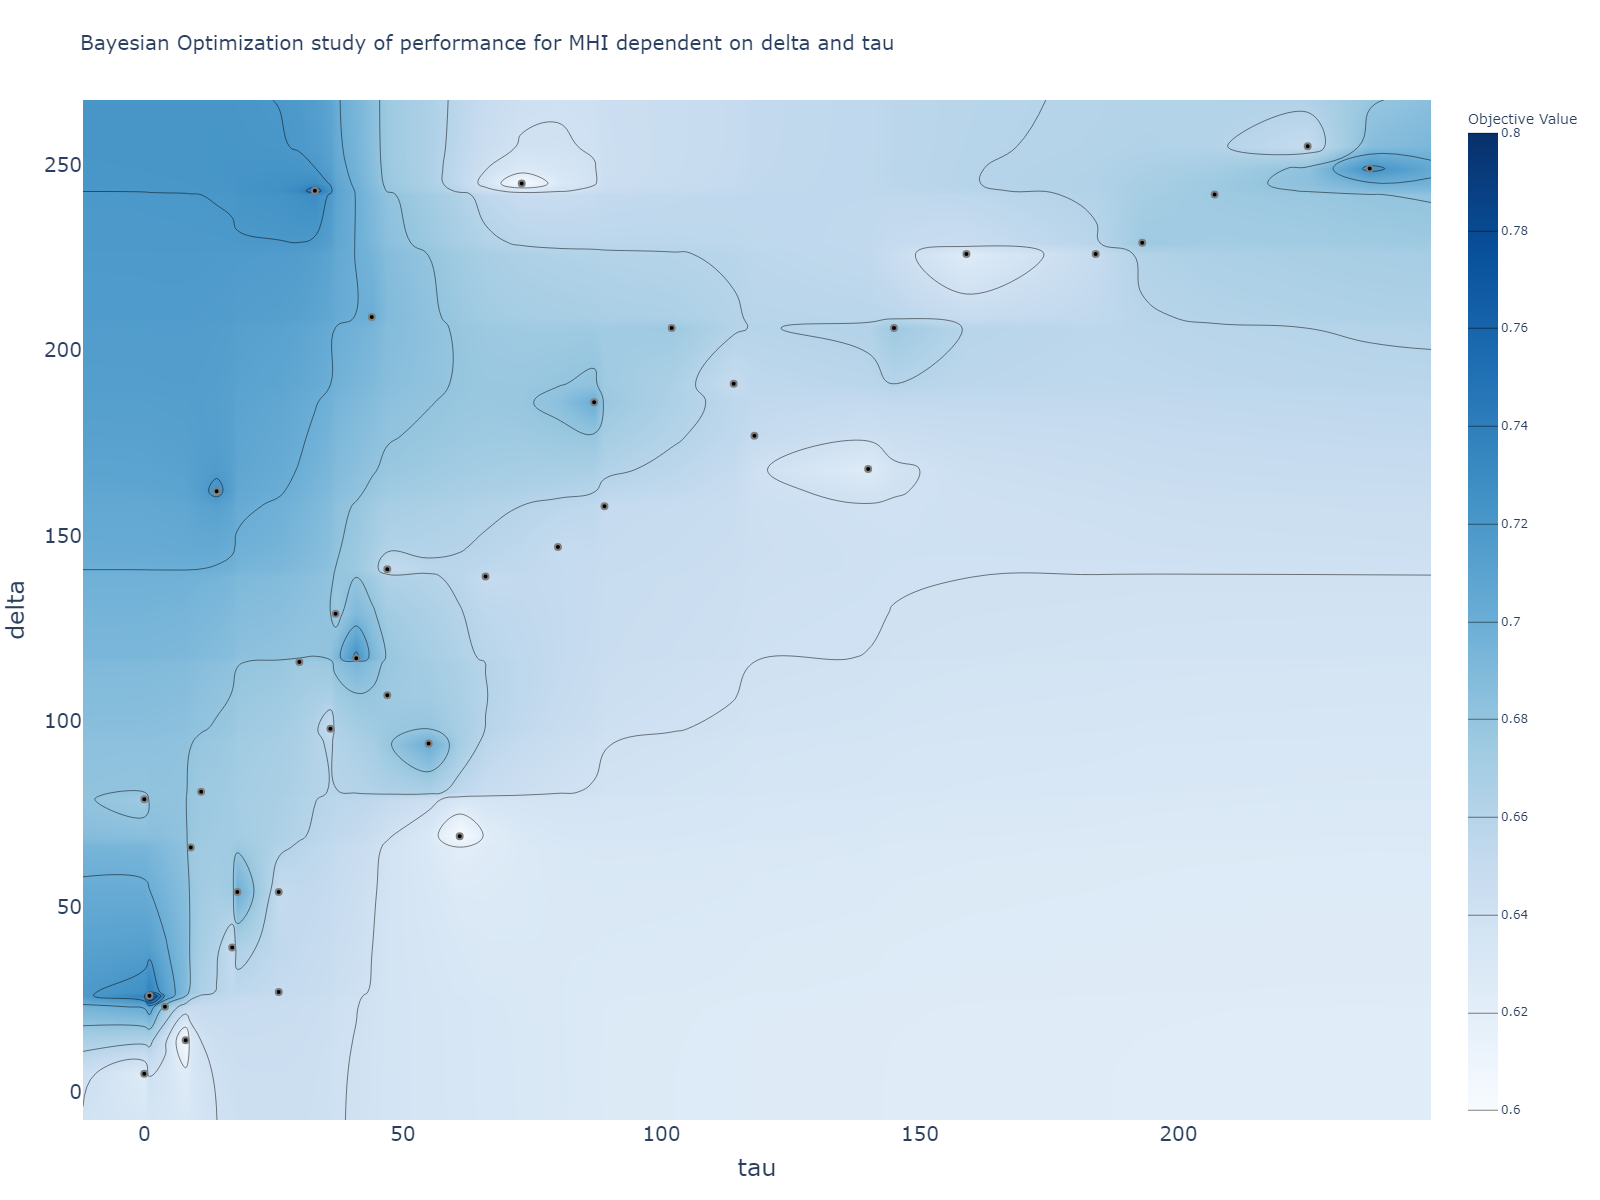

In [19]:
fig.update_layout(width=1200, height=1200)
# Update x-axis properties
fig.update_xaxes(
    title="tau",  # Set the name of the x-axis
    tickfont=dict(size=20),  # Set the size of tick labels
    title_font=dict(size=24) # Set the size of the axis title
)

# Update y-axis properties
fig.update_yaxes(
    title="delta",  # Set the name of the y-axis
    tickfont=dict(size=20),  # Set the size of tick labels
    title_font=dict(size=24) # Set the size of the axis title
)

fig.update_layout(title_text="Bayesian Optimization study of performance for MHI dependent on delta and tau", title_font_size=20)  # Set the title and its font size

fig.show()